# __3D TECHNOLOGIES__

__REPORT: On Reducing Maintenance Cost__


__Elaborated by: Sergio Nieto__

__Objective__

This document is a report on the work done by *The Data Science Team* building a predictive model using machine learning to predict the probability of a device failure. 

__Context__

The data is about a fleet of devices transmitting daily aggregated telemetry
attributes.
Predictive maintenance techniques are designed to help determine the condition of in-service equipment in order to predict when maintenance should be performed. This approach promises cost savings over routine or time-based preventive maintenance, because tasks are performed only when warranted.

In [2]:
# The libraries we'll use in this report are:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib.dates as dt
import matplotlib.lines as mlines
from IPython.core.pylabtools import figsize
import warnings
warnings.filterwarnings('ignore')
sns.set()

# Processing
from sklearn.preprocessing import FunctionTransformer,StandardScaler,PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split,KFold,GridSearchCV,RandomizedSearchCV, StratifiedKFold,cross_val_predict,cross_val_score,ShuffleSplit
from sklearn.feature_selection import SelectKBest, SelectFromModel
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.base import clone
from sklearn.decomposition import PCA

# Modelling
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

# Bayesian Modelling
import pymc3 as pm
import arviz as az
from collections import OrderedDict
import theano
import theano.tensor as tt
import itertools

# Deep Learning

# Evaluation
from sklearn.metrics import roc_curve,auc, roc_auc_score,accuracy_score, recall_score, f1_score, confusion_matrix, log_loss
from sklearn.metrics import classification_report, balanced_accuracy_score,precision_score,average_precision_score, precision_recall_curve

plt.rcParams['figure.figsize'] = (20, 10)
pd.set_option('display.max_columns', None)

In [7]:
from business import utils

In [3]:
np.random.seed(0)

In [3]:
# We check that it is a csv file
# cat device_failure.csv | head 
# shows no problem
# since we know nothing about the file encoding, latin-1 will be used.

# Exploratory Data Analysis 

In [4]:
devices = pd.read_csv("device_failure.csv", encoding='Latin-1')

In [8]:
devices.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [6]:
# Number of different devices

devices.device.nunique()

1169

In [7]:
# How many different dates?

devices.date.nunique()

304

In [8]:
# Not all devices have the same number of records
# This may be a disadvantage for a time series approach to detecting failure

# we take to examples from the previous head:

devices[devices.device == "S1F01085"]["date"].nunique()

6

In [9]:
devices[devices.device == "S1F01E6Y"]["date"].nunique()

48

In [10]:
# Before proceeding, we look at the info in the data frame:

devices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   date        124494 non-null  object
 1   device      124494 non-null  object
 2   failure     124494 non-null  int64 
 3   attribute1  124494 non-null  int64 
 4   attribute2  124494 non-null  int64 
 5   attribute3  124494 non-null  int64 
 6   attribute4  124494 non-null  int64 
 7   attribute5  124494 non-null  int64 
 8   attribute6  124494 non-null  int64 
 9   attribute7  124494 non-null  int64 
 10  attribute8  124494 non-null  int64 
 11  attribute9  124494 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 11.4+ MB


In [9]:
# We have more than 100 thounsand records, but haw many are failures?

devices.failure.value_counts(normalize=False)

0    124388
1       106
Name: failure, dtype: int64

In [10]:
# Date are converted to datetime from pandas in case we need to use later on these functionality

devices["date"]=pd.to_datetime(devices["date"])

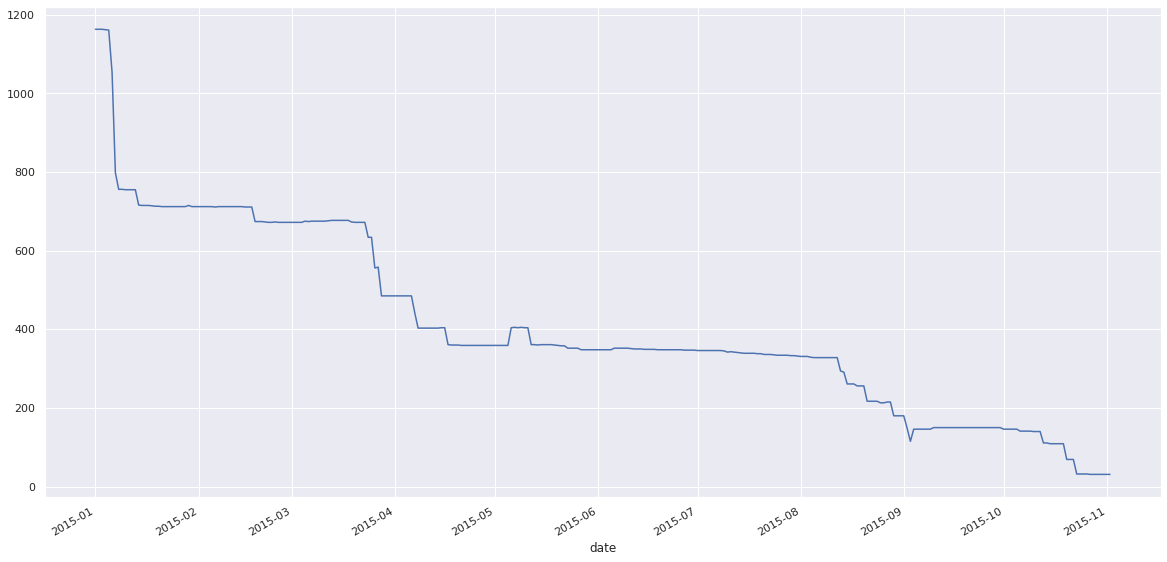

In [11]:
# Since we know

devices.groupby(["date"])["device"].nunique().plot()

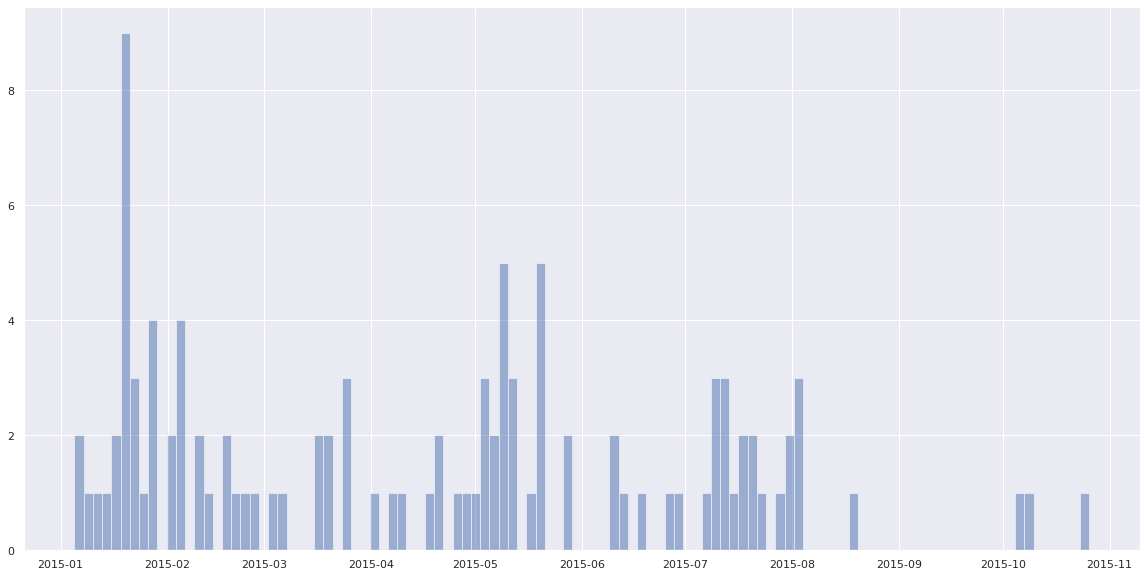

In [14]:
devices.query("(failure == 1)").date.hist(bins = 110, alpha = 0.5)

In [15]:
devices.groupby(["device"])["date"].count().describe()

count    1169.000000
mean      106.496151
std       102.651601
min         1.000000
25%         6.000000
50%        84.000000
75%       224.000000
max       304.000000
Name: date, dtype: float64

__Create a data frame based only on failures to understand better the structure of the time series__

In [26]:
list_failures=list(set(devices[devices.failure == 1]['device']))
devices.loc[devices.device.isin(list_failures),"tag"] = 1
devices.loc[~devices.device.isin(list_failures),"tag"] = 2

In [43]:
failures = devices[devices.tag == 1]
non_failures = devices[devices.tag == 2]

In [44]:
non_failures.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,tag
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7,2.0
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0,2.0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0,2.0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0,2.0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3,2.0


In [28]:
failures.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,tag
7,2015-01-01,S1F023H2,0,141503600,0,0,1,19,494462,16,16,3,1.0
23,2015-01-01,S1F03YZM,0,55587136,0,0,0,7,199132,0,0,0,1.0
44,2015-01-01,S1F09DZQ,0,12568128,136,0,2,6,380112,0,0,2,1.0
63,2015-01-01,S1F0CTDN,0,50147888,528,0,4,9,381198,32,32,3,1.0
74,2015-01-01,S1F0DSTY,0,8471680,0,0,0,11,436682,0,0,0,1.0


In [29]:
failures.device.nunique()

106

In [30]:
failures.groupby("device").date.describe().reset_index()

,device,count,unique,top,freq,first,last
0,S1F023H2,19,19,2015-01-04,1,2015-01-01,2015-01-19
1,S1F03YZM,215,215,2015-07-19,1,2015-01-01,2015-08-03
2,S1F09DZQ,199,199,2015-01-31,1,2015-01-01,2015-07-18
3,S1F0CTDN,7,7,2015-01-04,1,2015-01-01,2015-01-07
4,S1F0DSTY,45,45,2015-02-01,1,2015-01-01,2015-02-14
...,...,...,...,...,...,...,...
101,Z1F1901P,132,132,2015-01-07,1,2015-01-01,2015-05-12
102,Z1F1AG5N,9,9,2015-01-04,1,2015-01-01,2015-05-08
103,Z1F1FCH5,19,19,2015-01-04,1,2015-01-01,2015-01-19
104,Z1F1RJFA,124,124,2015-01-07,1,2015-01-01,2015-05-04


In [45]:
failures_desc = failures.groupby("device").date.describe().reset_index()
failures_desc.drop(["count","unique","top","freq"], axis=1, inplace=True)
non_failures_desc = non_failures.groupby("device").date.describe().reset_index()
non_failures_desc.drop(["count","unique","top","freq"], axis=1, inplace=True)
failures_desc.head()

,device,first,last
0,S1F023H2,2015-01-01,2015-01-19
1,S1F03YZM,2015-01-01,2015-08-03
2,S1F09DZQ,2015-01-01,2015-07-18
3,S1F0CTDN,2015-01-01,2015-01-07
4,S1F0DSTY,2015-01-01,2015-02-14


In [41]:
failures_desc["first"].describe()

count                     106
unique                      1
top       2015-01-01 00:00:00
freq                      106
first     2015-01-01 00:00:00
last      2015-01-01 00:00:00
Name: first, dtype: object

In [48]:
failures_desc.head()

,device,first,last
0,S1F023H2,2015-01-01,2015-01-19
1,S1F03YZM,2015-01-01,2015-08-03
2,S1F09DZQ,2015-01-01,2015-07-18
3,S1F0CTDN,2015-01-01,2015-01-07
4,S1F0DSTY,2015-01-01,2015-02-14


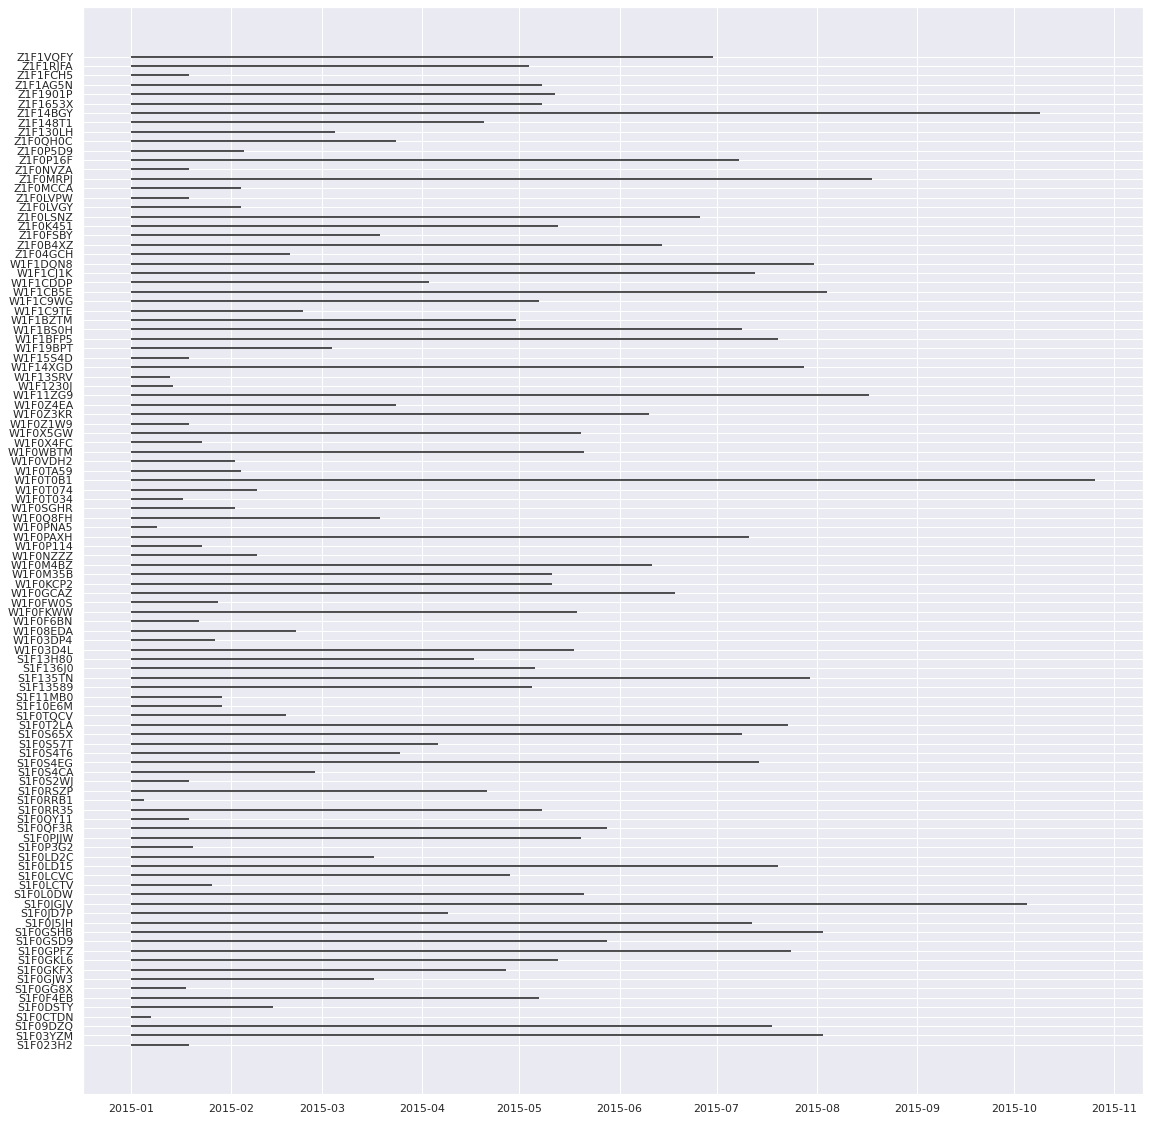

In [53]:
df = failures_desc.rename(columns={'device':'device',
                          'first':'Initial',
                          'last':'Final'})

fig = plt.figure(figsize=(19,20))
ax = fig.add_subplot(111)
ax = ax.xaxis_date()
ax = plt.hlines(df.device, dt.date2num(df.Initial), dt.date2num(df.Final))

In [59]:
failures[failures.device == "S1F0RRB1"]

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,tag
235,2015-01-01,S1F0RRB1,0,5230888,2288,0,37,8,39267,24,24,1,1.0
1398,2015-01-02,S1F0RRB1,0,13307628,64776,0,49,8,39267,56,56,1,1.0
2561,2015-01-03,S1F0RRB1,0,26258330,64776,0,135,8,39267,56,56,1,1.0
3724,2015-01-04,S1F0RRB1,0,37985862,64776,0,763,8,39267,56,56,1,1.0
4885,2015-01-05,S1F0RRB1,1,48467332,64776,0,841,8,39267,56,56,1,1.0


We do not have a regular pattern over a date range, failures can happen at week 2 or any other week. We cannot take this problem with a time series perspective since it'll have the property that predictions will be based on a window with only a week maybe two as history and the need to drop observations.

As a first conclusion, we have to treat this problem as a supervised machine learning problem, in particular a binary classification task on the target variable 'failure'.

# Data Processing and Feature selection

In [12]:
process_cols = ['attribute1', 'attribute2', 'attribute3',
       'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8','attribute9']

In [13]:
# A descriptive analysis will help to understand relation between variables
# 
devices[process_cols].describe()

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
count,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,1.223881e+08,159.484762,9.940455,1.741120,14.222669,260172.657726,0.292528,0.292528,12.451524
std,7.045933e+07,2179.657730,185.747321,22.908507,15.943028,99151.078547,7.436924,7.436924,191.425623
min,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,6.128476e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,1.227974e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,1.833096e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000


In [64]:
## It seems we have two very similar variables: attribute7 and attribute8

In [15]:
# We can also look at the correlation matrix between variables:

corr = devices[process_cols].corr() 
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
attribute1,1.000,-0.004,0.004,0.002,-0.003,-0.002,0.000,0.000,0.001
attribute2,-0.004,1.000,-0.003,0.147,-0.014,-0.026,0.141,0.141,-0.003
attribute3,0.004,-0.003,1.000,0.097,-0.007,0.009,-0.002,-0.002,0.532
attribute4,0.002,0.147,0.097,1.000,-0.010,0.025,0.046,0.046,0.036
attribute5,-0.003,-0.014,-0.007,-0.010,1.000,-0.017,-0.009,-0.009,0.006
attribute6,-0.002,-0.026,0.009,0.025,-0.017,1.000,-0.012,-0.012,0.021
attribute7,0.000,0.141,-0.002,0.046,-0.009,-0.012,1.000,1.000,0.007
attribute8,0.000,0.141,-0.002,0.046,-0.009,-0.012,1.000,1.000,0.007
attribute9,0.001,-0.003,0.532,0.036,0.006,0.021,0.007,0.007,1.000


We can see a very important issue here: attribute7 and attribute8 have correlation 1 and the same distribution. 

Most likely they are equal, but still no new information will be generated by keeping both variables.

In [16]:
devices.drop(columns=["attribute7"], axis=1, inplace=True)

# And we remove it also from the list of attributes for processing

process_cols.remove('attribute7')

In [17]:
# We can look now to linear correlation between variables and the target:

devices.corr()['failure'].sort_values(ascending=False)

failure       1.000000
attribute8    0.119055
attribute4    0.067398
attribute2    0.052902
attribute5    0.002270
attribute1    0.001983
attribute9    0.001622
attribute6   -0.000550
attribute3   -0.000948
Name: failure, dtype: float64

__Feature Selection__

 Before we proceed to selection method, attributes need to be standarized since ranges differ from each other and this will cause truble with selection by logistic regression.

In [19]:
# We create two pipelines for processing data so that we have them available for later use:

# We reserve PCA pipeline if needed.

num_pipeline = Pipeline([
    ("estandarizador", StandardScaler())
])


pipeline = ColumnTransformer([
    ("cont", num_pipeline, process_cols)#,
    #("pcas", PCA(n_components = 1, random_state=2020), process_cols)
])

In [20]:
df_num = pipeline.fit_transform(devices)

In [21]:
std_cols = ['x1', 'x2', 'x3' , 'x4', 'x5', 'x6', 'x7' , 'x8']

In [22]:
df_num = pd.DataFrame(df_num, columns=std_cols)

In [23]:
df_num["y"] = devices["failure"]

In [24]:
df_num.head()

,x1,x2,x3,x4,x5,x6,x7,x8,y
0,1.323358,-0.047478,-0.053516,2.193905,-0.515755,1.485268,-0.039335,-0.028479,0
1,-0.865998,-0.073170,-0.037365,-0.076004,-0.515755,1.442263,-0.039335,-0.065047,0
2,0.722517,-0.073170,-0.053516,-0.076004,-0.139414,-0.229738,-0.039335,-0.065047,0
3,-0.605942,-0.073170,-0.053516,-0.076004,-0.515755,1.512983,-0.039335,-0.065047,0
4,0.192770,-0.073170,-0.053516,-0.076004,0.048757,0.534543,-0.039335,-0.049375,0


In [25]:
X = df_num[std_cols].values
Y = df_num.y

In [167]:
poly = PolynomialFeatures(interaction_only=True)
X_int = poly.fit_transform(X)

In [168]:
selector = SelectFromModel(estimator=LogisticRegression(class_weight='balanced',
                                                        max_iter=200,
                                                        random_state=2020), 
                           threshold = 'median').fit(X_int, Y)
selector.estimator_.coef_

array([[-0.49533753,  0.18914722,  1.24371904, -5.52573988,  0.84532227,
        -0.23263094,  0.28724526,  1.48718155, -1.41304512, -0.11276852,
         1.85475531, -0.28057735,  0.17412718, -0.01439656,  0.44078069,
         1.52082723, -0.29364314, -0.02108822,  0.97060255,  0.91767086,
        -0.41926479,  1.03249105, -3.81830848, -6.05914619,  4.65637122,
        -0.47385241, -0.50548736,  0.65569993, -0.77778383,  0.14528875,
        -3.29678448,  0.39791156,  0.45544156, -1.15487165,  0.18035603,
        -0.51614393, -0.13894346]])

In [169]:
selector.get_support()

array([False, False,  True,  True,  True, False, False,  True,  True,
       False,  True, False, False, False, False,  True, False, False,
        True,  True, False,  True,  True,  True,  True, False,  True,
        True,  True, False,  True, False, False,  True, False,  True,
       False])

In [170]:
selector.threshold_

0.5054873617015109

We have a second conclusion: by feature selection with a logistic regression, we can drop the nearly uniformly distributed variable: attribute1 and others that show almost no correlation to the target. 

This is only a way to select a *strategy*: first we'll try with all the variables and only drop the ones we detect here to get better performance.

A third conclusion is the need for *interactions*, these mean nonlinear relation between attributes to help predicting the target. This points us in the following direction: we can try again logistic regression, but better fitted, with the interactions in mind and perhaps try to fit a model using bayesian techniques to quantify uncertainty in the coefficients. 

Another direction to take thes nonlinear relations into account is the use of tree-based algorithms.

So, now we can draw a strategy for modelling: we'll try logit as benchmark and from there we can search for tree-based algorithms. Since nonlinear relations seem to be in the play, we can also try neural network architecture to solve our classification task.

# Modelling: Benchmark

In [68]:
###################
# target variable
y = devices.failure
###################

# We separate in train and test sets to measure the performance and to test generalization capacity of the models.

X_train, X_test, y_train, y_test = train_test_split(devices[process_cols],y,
                                                    test_size=0.3, 
                                                    stratify= y, 
                                                    random_state=2020)

# For the case of logistic regression we use the standarization pipeline build before.
# We apply it in separate to avoid data leakage

X_train_lg = pipeline.fit_transform(X_train)
X_test_lg = pipeline.fit_transform(X_test)

#################################################

 Because we are dealing with imbalanced classes, not too many failures, it is a good practice to use a library to help over samplig.

 SMOTE is a technique used to help in the situation we have.

 SMOTE was proposed in 

 Bowyer, et al., 2002, SMOTE: Synthetic Minority Over-sampling Technique, 
 Journal of Artificial Intelligence Research 16 (2002) 321–357 
 (https://arxiv.org/pdf/1106.1813.pdf, accessed on July 2020).

In [32]:
sm = SMOTE(random_state = 2)

# over sampling for logit:

X_train_rlg, y_train_rlg = sm.fit_sample(X_train_lg, y_train.ravel())

# We'll try tree based algorithms so we have no need to stadandarize, but still have to balance the sets:

X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

In [33]:
y_train_rlg = pd.DataFrame(y_train_rlg, columns=['y'])
X_train_rlg = pd.DataFrame(X_train_rlg, columns=process_cols)
#y_train_rlg.head()

In [43]:
# Next we create the train pipelines for the benchmarks.

# The first is the base logistic regression:

penalty = 'l2'
C = 0.5
class_weight = 'balanced'
random_state = 2020
solver = 'liblinear'

logReg = LogisticRegression(penalty=penalty, 
                            C=C,
                            class_weight=class_weight, 
                            random_state=random_state,
                            solver=solver, 
                            n_jobs=-1)

In [44]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],
                                        index=y_train_rlg.index,columns=[0,1])

model = logReg


k_fold = StratifiedKFold(n_splits=5,shuffle=True,random_state=2020)

In [45]:
for train_index, cv_index in k_fold.split(np.zeros(len(X_train_rlg)),y_train_rlg.y.ravel()):
    X_train_fold, X_cv_fold = X_train_rlg.iloc[train_index,:],X_train_rlg.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train_rlg.iloc[train_index],y_train_rlg.iloc[cv_index]
    
    model.fit(X_train_fold, y_train_fold)
    loglossTraining = log_loss(y_train_fold, model.predict_proba(X_train_fold)[:,1])
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,:] = model.predict_proba(X_cv_fold)  
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFolds.loc[X_cv_fold.index,1])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossLogisticRegression = log_loss(y_train_rlg, predictionsBasedOnKFolds.loc[:,1])
print('Logistic Regression Log Loss: ', loglossLogisticRegression)

Training Log Loss:  0.5492905116972435
CV Log Loss:  0.5481947137053443
Training Log Loss:  0.5481535882873572
CV Log Loss:  0.5526379303687012
Training Log Loss:  0.5486941215740074
CV Log Loss:  0.552015514669048
Training Log Loss:  0.5483518933188506
CV Log Loss:  0.5526713114013646
Training Log Loss:  0.5517897733247721
CV Log Loss:  0.5416488242331747
Logistic Regression Log Loss:  0.5494336701612952


Optimal Threshold=0.356528, F-Score=0.737


Text(0.5, 1.0, 'Precision-Recall curve: Average Precision = 0.83')

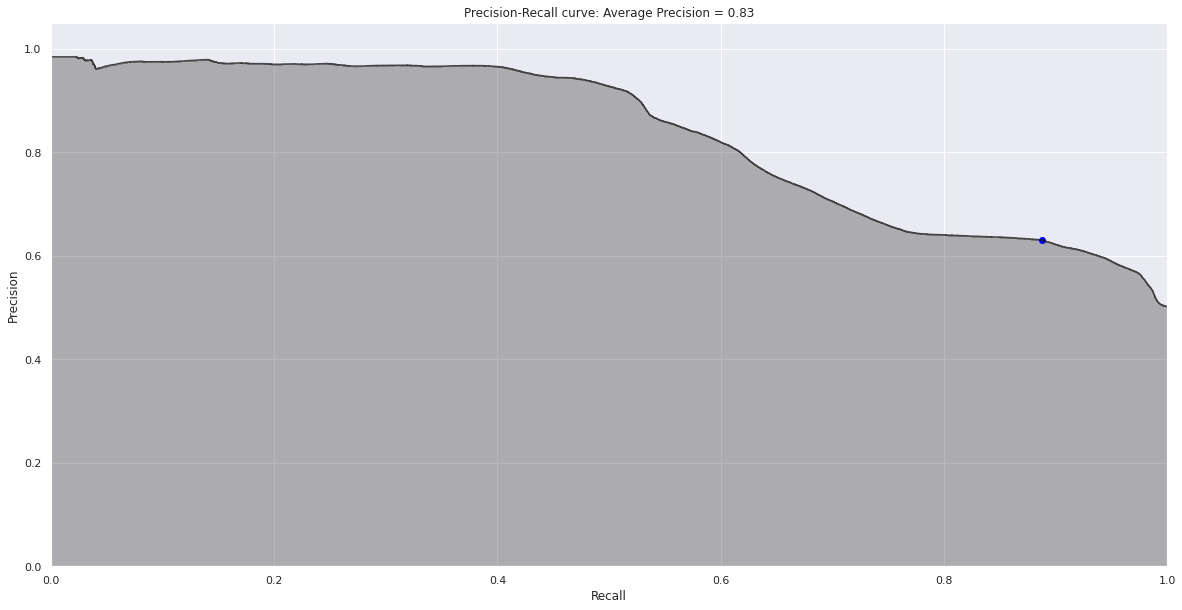

In [46]:
preds = pd.concat([y_train_rlg,predictionsBasedOnKFolds.loc[:,1]], axis=1)
preds.columns = ['trueLabel','prediction']
predictionsBasedOnKFoldsLogisticRegression = preds.copy()
precision, recall, thresholds = precision_recall_curve(preds['trueLabel'],
                                                       preds['prediction'])
average_precision = average_precision_score(preds['trueLabel'],
                                            preds['prediction'])
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
corte = np.argmax(fscore)
print('Optimal Threshold=%f, F-Score=%.3f' % (thresholds[corte], fscore[corte]))


plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')
plt.scatter(recall[corte], precision[corte], marker='o', color='blue', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

Optimal Threshold=0.466013


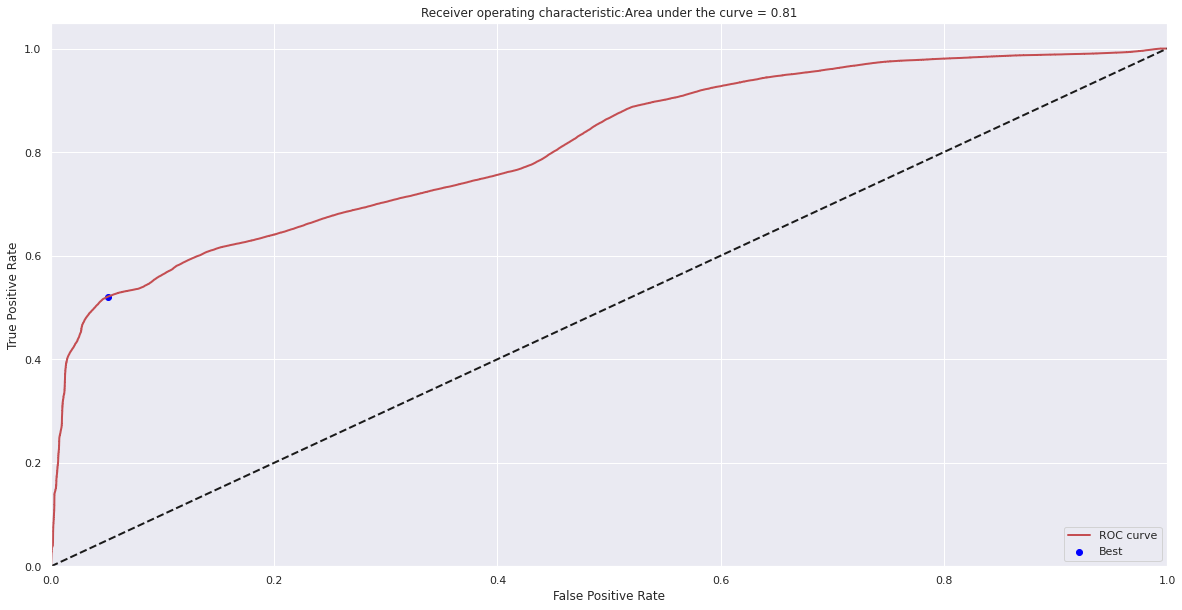

In [47]:
fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])

areaUnderROC = auc(fpr, tpr)

# To find the best threshold we can use Youden's statistic 
# J = Sensitivity + Specificity – 1
# https://en.wikipedia.org/wiki/Youden%27s_J_statistic

# But we have that Sensitivity is the True Positive Rate
# And then J = Sensitivity + (1 – FalsePositiveRate) – 1
# Then

J = tpr - fpr
optim = np.argmax(J)
best_thresh = thresholds[optim]
print('Optimal Threshold=%f' % (best_thresh))


plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
# optimal point
plt.scatter(fpr[optim], tpr[optim], marker='o', color='blue', label='Best')
#
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic:Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

# MODEL 2: LOGISTIC REGRESSION WITH INTERACTIONS

The second model will contain all variables and their interactions but no powers of the variables.

In [82]:
num_pipeline = Pipeline([
    ("estandarizador", StandardScaler())
])

int_pipeline = Pipeline([
    ("estandarizador", StandardScaler()),
    ("interacciones", PolynomialFeatures(interaction_only=True))
])

pipeline_int = ColumnTransformer([
    ("int", int_pipeline, process_cols)])

In [84]:
# Applying the new pipeline:

X_train_lg2 = pipeline_int.fit_transform(X_train)
X_test_lg2 = pipeline_int.fit_transform(X_test)

In [85]:
X_train_rlg2, y_train_rlg2 = sm.fit_sample(X_train_lg2, y_train.ravel())

In [86]:
y_train_rlg2 = pd.DataFrame(y_train_rlg2, columns=['y'])
X_train_rlg2 = pd.DataFrame(X_train_rlg2)
#y_train_rlg.head() , columns=process_cols

In [87]:
X_train_rlg2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36
0,1.0,-0.670981,-0.066263,-0.051656,-0.077427,0.552642,-2.615636,-0.038215,-0.066249,0.044461,0.034660,0.051952,-0.370812,1.755043,0.025642,0.044452,0.003423,0.005131,-0.036620,0.173320,0.002532,0.004390,0.004,-0.028547,0.135112,0.001974,0.003422,-0.042790,0.202522,0.002959,0.005129,-1.445510,-0.021119,-0.036612,0.099957,0.173282,0.002532
1,1.0,-1.147815,-0.073744,-0.051656,-0.077427,-0.201270,-0.613338,-0.038215,-0.066249,0.084644,0.059291,0.088872,0.231021,0.703998,0.043864,0.076041,0.003809,0.005710,0.014842,0.045230,0.002818,0.004885,0.004,0.010397,0.031682,0.001974,0.003422,0.015584,0.047489,0.002959,0.005129,0.123447,0.007692,0.013334,0.023439,0.040633,0.002532
2,1.0,-0.317916,-0.073744,-0.051656,-0.077427,4.761984,-0.349450,-0.038215,-0.066249,0.023444,0.016422,0.024615,-1.513913,0.111096,0.012149,0.021062,0.003809,0.005710,-0.351167,0.025770,0.002818,0.004885,0.004,-0.245983,0.018051,0.001974,0.003422,-0.368707,0.027057,0.002959,0.005129,-1.664078,-0.181980,-0.315475,0.013354,0.023151,0.002532
3,1.0,-1.371747,-0.073744,-0.051656,-0.077427,-0.452574,-0.245283,-0.038215,-0.055442,0.101158,0.070858,0.106211,0.620818,0.336466,0.052421,0.076052,0.003809,0.005710,0.033375,0.018088,0.002818,0.004088,0.004,0.023378,0.012670,0.001974,0.002864,0.035042,0.018992,0.002959,0.004293,0.111009,0.017295,0.025092,0.009374,0.013599,0.002119
4,1.0,-0.110690,-0.073744,-0.051656,-0.077427,-0.389748,0.535118,-0.038215,-0.066249,0.008163,0.005718,0.008570,0.043141,-0.059232,0.004230,0.007333,0.003809,0.005710,0.028742,-0.039462,0.002818,0.004885,0.004,0.020133,-0.027642,0.001974,0.003422,0.030177,-0.041433,0.002959,0.005129,-0.208561,0.014894,0.025820,-0.020450,-0.035451,0.002532


In [90]:
# Next we create the train pipelines for the benchmarks.

# The first is the base logistic regression:

penalty = 'l2'
C = 0.4
class_weight = 'balanced'
random_state = 2020
solver = 'liblinear'

logReg = LogisticRegression(penalty=penalty, 
                            C=C,
                            max_iter = 500, 
                            warm_start = True,
                            #class_weight=class_weight, 
                            random_state=random_state,
                            solver=solver, 
                            n_jobs=-1
                           )

trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],
                                        index=y_train_rlg2.index,columns=[0,1])

model = logReg

In [91]:
for train_index, cv_index in k_fold.split(np.zeros(len(X_train_rlg2)),y_train_rlg2.y.ravel()):
    X_train_fold, X_cv_fold = X_train_rlg2.iloc[train_index,:],X_train_rlg2.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train_rlg2.iloc[train_index],y_train_rlg2.iloc[cv_index]
    
    model.fit(X_train_fold, y_train_fold)
    loglossTraining = log_loss(y_train_fold, model.predict_proba(X_train_fold)[:,1])
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,:] = model.predict_proba(X_cv_fold)  
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFolds.loc[X_cv_fold.index,1])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossLogisticRegression = log_loss(y_train_rlg2, predictionsBasedOnKFolds.loc[:,1]) 
#l1 y C=.4 Logistic Regression with interactions Log Loss:  0.47963111564766253
print('Logistic Regression with interactions Log Loss: ', loglossLogisticRegression) 
#Logistic Regression Log Loss:  0.5289955008268935

Training Log Loss:  0.5000650310296977
CV Log Loss:  0.5036891819199959
Training Log Loss:  0.5024513130533012
CV Log Loss:  0.4991846853788029
Training Log Loss:  0.5001721308691905
CV Log Loss:  0.5065359423281001
Training Log Loss:  0.4998058292759337
CV Log Loss:  0.5078021960196831
Training Log Loss:  0.5037710680391275
CV Log Loss:  0.49585641843318284
Logistic Regression with interactions Log Loss:  0.5026136713011069


Optimal Threshold=0.360420, F-Score=0.783


Text(0.5, 1.0, 'Precision-Recall curve: Average Precision = 0.88')

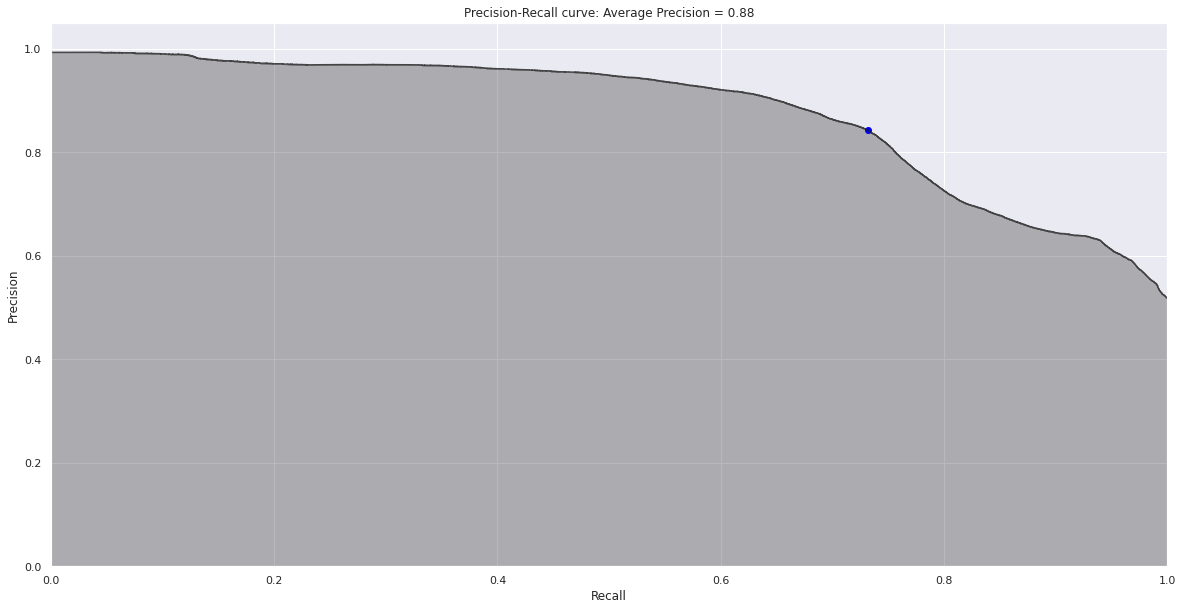

In [92]:
preds = pd.concat([y_train_rlg2,predictionsBasedOnKFolds.loc[:,1]], axis=1)
preds.columns = ['trueLabel','prediction']
predictionsBasedOnKFoldsLogisticRegression = preds.copy()

precision, recall, thresholds = precision_recall_curve(preds['trueLabel'],
                                                       preds['prediction'])

average_precision = average_precision_score(preds['trueLabel'],
                                            preds['prediction'])

# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
corte = np.argmax(fscore)
print('Optimal Threshold=%f, F-Score=%.3f' % (thresholds[corte], fscore[corte]))

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')
plt.scatter(recall[corte], precision[corte], marker='o', color='blue', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

Optimal Threshold=0.364441


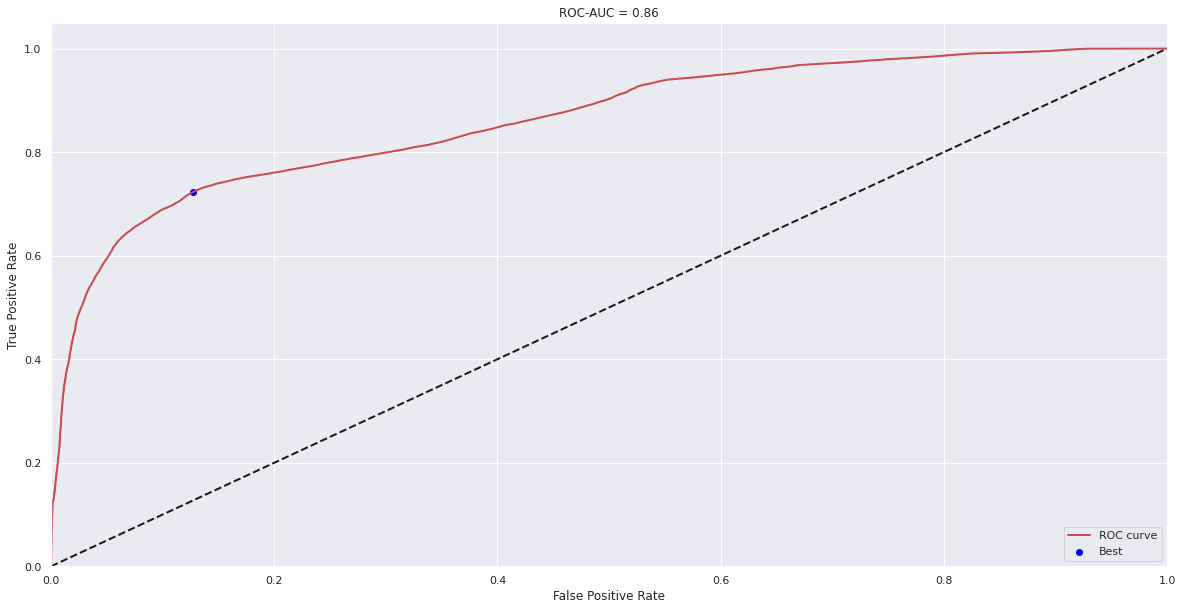

In [93]:
fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])

areaUnderROC = auc(fpr, tpr)

J = tpr - fpr
optim = np.argmax(J)
best_thresh = thresholds[optim]
print('Optimal Threshold=%f' % (best_thresh))

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
# optimal point
plt.scatter(fpr[optim], tpr[optim], marker='o', color='blue', label='Best')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

# MODEL 3: RANDOM FOREST

We'll try a tree based classifier.

In this case we do not need the standirized variables.

The following steps represent one way to search for hyperparameters in a given range.

In [100]:
pipe_rf = Pipeline([('classifier' , RandomForestClassifier(random_state=2020))])

param_grid_rf = [
    {'classifier' : [RandomForestClassifier(random_state=2020,
                                            criterion="gini", 
                                            max_features="auto", 
                                            oob_score= True
                                            #class_weight="balanced",
                                            )],
    'classifier__n_estimators' : list(range(200,381,20)),
    'classifier__max_depth' : list(range(7,9,1))
    } 
]

In [101]:
clf_rf = GridSearchCV(pipe_rf, param_grid = param_grid_rf, cv = 5, verbose=True, n_jobs=-1) #cambiar a 5

In [102]:
best_rf = clf_rf.fit(X_train_res, y_train_res)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 11.7min finished


In [103]:
print(best_rf.best_estimator_.get_params()['classifier'])

RandomForestClassifier(max_depth=8, n_estimators=260, oob_score=True,
                       random_state=2020)


In [106]:
print('Accuracy en entrenamiento rf',best_rf.score(X_train_res, y_train_res))
print('Accuracy en prueba rf',best_rf.score(X_test, y_test))

Accuracy en entrenamiento rf 0.9501785898864146
Accuracy en prueba rf 0.9623550831347559


In [107]:
classes_rf = best_rf.predict(X_test)
print(classification_report(classes_rf, y_test))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     35939
           1       0.56      0.01      0.02      1410

    accuracy                           0.96     37349
   macro avg       0.76      0.51      0.50     37349
weighted avg       0.95      0.96      0.94     37349



We just found the best hyperparameters in a test range. Now we retrain the best model using k-fold cross validation.

In [ ]:
for train_index, cv_index in k_fold.split(np.zeros(len(X_train_rlg2)),y_train_rlg2.y.ravel()):
    X_train_fold, X_cv_fold = X_train_rlg2.iloc[train_index,:],X_train_rlg2.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train_rlg2.iloc[train_index],y_train_rlg2.iloc[cv_index]
    
    model.fit(X_train_fold, y_train_fold)
    loglossTraining = log_loss(y_train_fold, model.predict_proba(X_train_fold)[:,1])
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,:] = model.predict_proba(X_cv_fold)  
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFolds.loc[X_cv_fold.index,1])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossLogisticRegression = log_loss(y_train_rlg2, predictionsBasedOnKFolds.loc[:,1]) 
#l1 y C=.4 Logistic Regression with interactions Log Loss:  0.47963111564766253
print('Logistic Regression with interactions Log Loss: ', loglossLogisticRegression) 
#Logistic Regression Log Loss:  0.5289955008268935

In [ ]:
pipe_rf = Pipeline([('classifier' , RandomForestClassifier(random_state=20200611))])


pipe_gb = Pipeline([('classifier' , GradientBoostingClassifier(random_state=20200611))])


#########################
click.echo("Se crea la malla para hiperparámetros de RF")
##########################


param_grid_rf = [
    {'classifier' : [RandomForestClassifier(random_state=20200611,
                                            criterion="gini", 
                                            max_features="auto", 
                                            oob_score= True,
                                            #class_weight="balanced",
                                            n_jobs=-1)],
    'classifier__n_estimators' : list(range(200,681,20)),
    'classifier__max_depth' : list(range(4,11,1))
    } 
]



param_grid_gb = [
    {'classifier' : [GradientBoostingClassifier(random_state=20200611, 
    validation_fraction=0.1)],
    'classifier__learning_rate' : list(np.logspace(-4.8, -1.2, 8)), 
    'classifier__subsample' : list(np.logspace(-.2, -.01, 5)), 
    'classifier__n_estimators' : list(range(540,601,20)),
    'classifier__max_features' : list(range(7,11,1)),
    'classifier__n_iter_no_change' : list(range(7,11,1))
    }
]


# Se usan 5 para prueba, aunque no es necesario subirle


clf_ode_rf = GridSearchCV(pipe_rf, param_grid = param_grid_rf, cv = 5, verbose=True, n_jobs=-1) #cambiar a 5

clf_ode_gb = GridSearchCV(pipe_gb, param_grid = param_grid_gb, cv = 5, verbose=True, n_jobs=-1) #cambiar a 5

#click.echo("Corriendo grid search para el mejor clasificador RF")
#best_clf_ode_rf = clf_ode_rf.fit(X_train_res, y_train_res)


#click.echo("Corriendo grid search para el mejor clasificador GB")
#best_clf_ode_gb = clf_ode_gb.fit(X_train_res, y_train_res)


# Mejores modelos
#print(best_clf_ode_rf.best_estimator_.get_params()['classifier'])
#print(best_clf_ode_gb.best_estimator_.get_params()['classifier'])


# Métricas
#print('Accuracy en entrenamiento rf',best_clf_ode_rf.score(X_train_prep, y_train))
#print('Accuracy en prueba rf',best_clf_ode_rf.score(X_test_prep, y_test))

#print('Accuracy en entrenamiento gb',best_clf_ode_gb.score(X_train_prep, y_train))
#print('Accuracy en prueba gb',best_clf_ode_gb.score(X_test_prep, y_test))

# Reportes
#click.echo("Reporte de clasificación para el mejor clasificador rf")
#classes_rf = best_clf_ode_rf.predict(X_test_prep)
#print(classification_report(classes_rf, y_test))

#click.echo("Reporte de clasificación para el mejor clasificador gb")
#classes_gb = best_clf_ode_gb.predict(X_test_prep)
#print(classification_report(classes_gb, y_test))
#
# 
# Guardando

#filename_rf = 'ode_model_train_RFreducedvar.pkl'

#pickle.dump(best_clf_ode_rf, open('/pfs/out/ode_model_train_RFreducedvar.pkl', 'wb'))

#click.echo("Modelo RFC con reducción dimensional: {} escrito".format(filename_rf))

#filename_gb = 'ode_model_train_GBreducedvar.pkl'

#pickle.dump(best_clf_ode_gb, open('/pfs/out/ode_model_train_GBreducedvar.pkl', 'wb'))

#click.echo("Modelo GBC con reducción dimensional: {} escrito".format(filename_gb))

# Modelos sin grid search

# Son para comparación

# Transformaciones de variables para entrenamiento

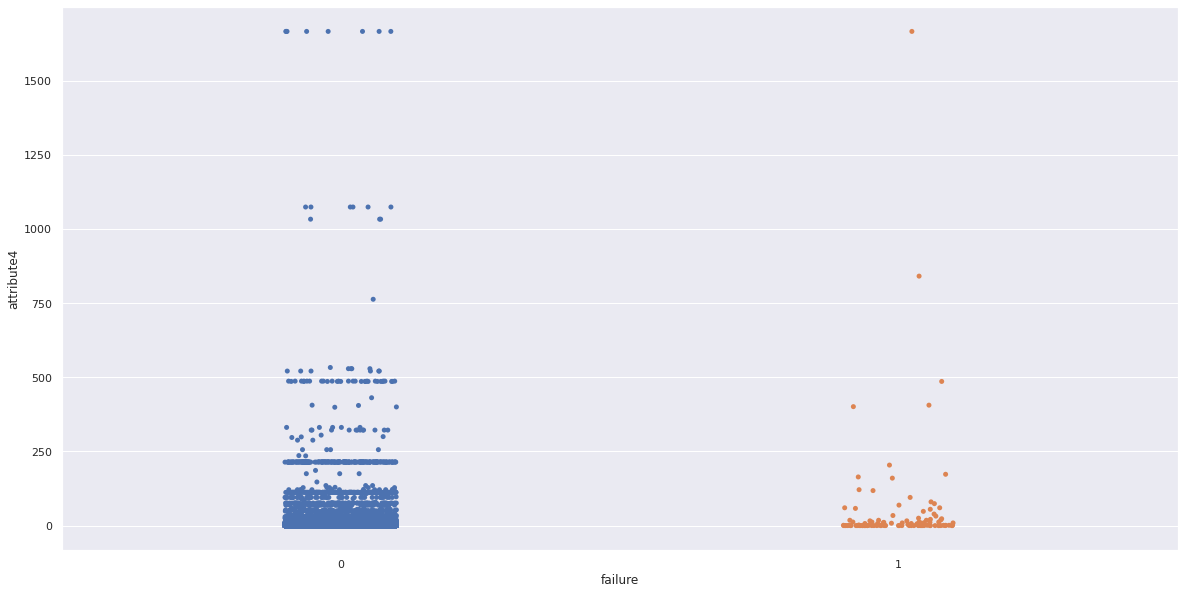

In [82]:
# Correlated variables with target may show some ranges of interest:

sns.stripplot(x="failure", y="attribute4", data=devices, jitter=True)
plt.show();

# Pendientes

### 1. Pca no ha sido probada como opción
### 2. Prototipo: regresión logística con y sin interacciones.
### 3. Paso 2: métodos de árboles
### 4. Paso 3: red neuronal
### 5. Paso 4: Deteccion de anomalías: PCA, SOM SOLO SI DA TIEMPO
### 6. Evaluaciones: tabla comparativa de performance